In [ ]:
!pip install mplsoccer

In [36]:
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



# Load your data (assuming you have separate DataFrames for each era)
df_luis = pd.read_csv("/content/sample_data/barca_filtered_events_luis.csv")  # Luis Enrique era
df_valverde = pd.read_csv("/content/sample_data/barca_filtered_events_after.csv")  # Valverde era

# Filter for only pass events
luis_passes = df_luis[df_luis['event_type'] == 'Pass'].copy()
valverde_passes = df_valverde[df_valverde['event_type'] == 'Pass'].copy()

In [38]:
#Boolean column to check percentage of forward passes
# Luis Enrique era
luis_passes['is_progressive'] = (luis_passes['pass_end_x'] - luis_passes['location_x']) > 10

# Valverde era
valverde_passes['is_progressive'] = (valverde_passes['pass_end_x'] - valverde_passes['location_x']) > 10

#Percentage
prog_pct_luis = luis_passes['is_progressive'].mean() * 100
prog_pct_valverde = valverde_passes['is_progressive'].mean() * 100

print(f"Progressive Pass % - Luis Enrique: {prog_pct_luis:.2f}%")
print(f"Progressive Pass % - Ernesto Valverde: {prog_pct_valverde:.2f}%")



Progressive Pass % - Luis Enrique: 28.96%
Progressive Pass % - Ernesto Valverde: 26.56%


luis have more forward percentage then Valverde
in professional football 2.4 is a much larger difference

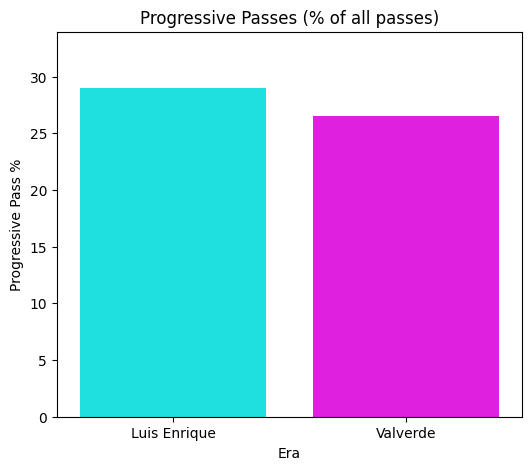

In [39]:
prog_data = {
    'Era': ['Luis Enrique', 'Valverde'],
    'Progressive Pass %': [prog_pct_luis, prog_pct_valverde]
}
df_prog = pd.DataFrame(prog_data)

plt.figure(figsize=(6, 5))
sns.barplot(x='Era', y='Progressive Pass %', data=df_prog, palette=['cyan', 'magenta'])
plt.title('Progressive Passes (% of all passes)')
plt.ylim(0, max(df_prog['Progressive Pass %']) + 5)
plt.show()

In [40]:


#   ensureing  data is sorted by time for logical reason.
#
df_luis = df_luis.sort_values(by=['match_id', 'minute', 'second']).reset_index(drop=True)
df_valverde = df_valverde.sort_values(by=['match_id', 'minute', 'second']).reset_index(drop=True)

#  For Luis Enrique's DataFrame

# a boolean column that is True whenever the possession_team is different from the previous row so we can assign the unique ID to each possession chain.
#here i have deffined by possesion chain as the interrupted sequence of series where ball reamins with a particular team
# The .shift(1) method looks at the value from the row directly above.
df_luis['possession_change'] = df_luis['possession_team'] != df_luis['possession_team'].shift(1)

# Now, we assign a unique ID to each possession chain using possession_change boolean column
# The .cumsum() method adds up the True values (which are treated as 1).
# Every time a new possession starts (possession_change is True), the ID number increases by one.
df_luis['possession_id'] = df_luis['possession_change'].cumsum()


#

df_valverde['possession_change'] = df_valverde['possession_team'] != df_valverde['possession_team'].shift(1)
df_valverde['possession_id'] = df_valverde['possession_change'].cumsum()

In [41]:
def analyze_possession_chains(df, team_name='Barcelona'):
    """
    This function takes a dataframe with possession IDs and calculates key stats for each chain.
    """
    # selectiong only barca possession
    barca_possessions = df[df['possession_team'] == team_name]

    # Group by each unique possession chain so that we have a possesion at a time
    grouped = barca_possessions.groupby('possession_id')

    # Create a list to store the results for each chain
    chain_stats_list = []

    for name, chain in grouped:
        #name is id and chain is group of event
        # Geting the start time of the chain (from the very first event in a particular group) in Seconds
        start_time = chain['minute'].iloc[0] * 60 + chain['second'].iloc[0]

        # Time to Final Third
        # Filter for events that occurred in the final third (x > 80)
        final_third_events = chain[chain['location_x'] > 80]
        time_to_final_third = None # Default to None if they never reach it
        if not final_third_events.empty:
            # Get the time of the *first* event in the final third
            first_entry_time = final_third_events['minute'].iloc[0] * 60 + final_third_events['second'].iloc[0]
            time_to_final_third = first_entry_time - start_time

        #  Time to Shot
        # Filter for shot events within the chain
        shot_events = chain[chain['event_type'] == 'Shot']
        time_to_shot = None # Default to None if no shot was taken
        if not shot_events.empty:
            # Get the time of the *first* shot
            first_shot_time = shot_events['minute'].iloc[0] * 60 + shot_events['second'].iloc[0]
            time_to_shot = first_shot_time - start_time

        # Add the results for this chain to our list
        chain_stats_list.append({
            'possession_id': name,
            'time_to_final_third': time_to_final_third,
            'time_to_shot': time_to_shot
        })

    return pd.DataFrame(chain_stats_list)

#  applying this function to both of our dataframes
luis_chain_stats = analyze_possession_chains(df_luis)
valverde_chain_stats = analyze_possession_chains(df_valverde)

# Displaying the results
print("Luis Enrique - Chain Analysis Sample:")
print(luis_chain_stats.head())


Luis Enrique - Chain Analysis Sample:
   possession_id  time_to_final_third  time_to_shot
0              1                  NaN           NaN
1              3                 22.0           NaN
2              5                 22.0           NaN
3              7                 22.0           NaN
4              9                 44.0           NaN


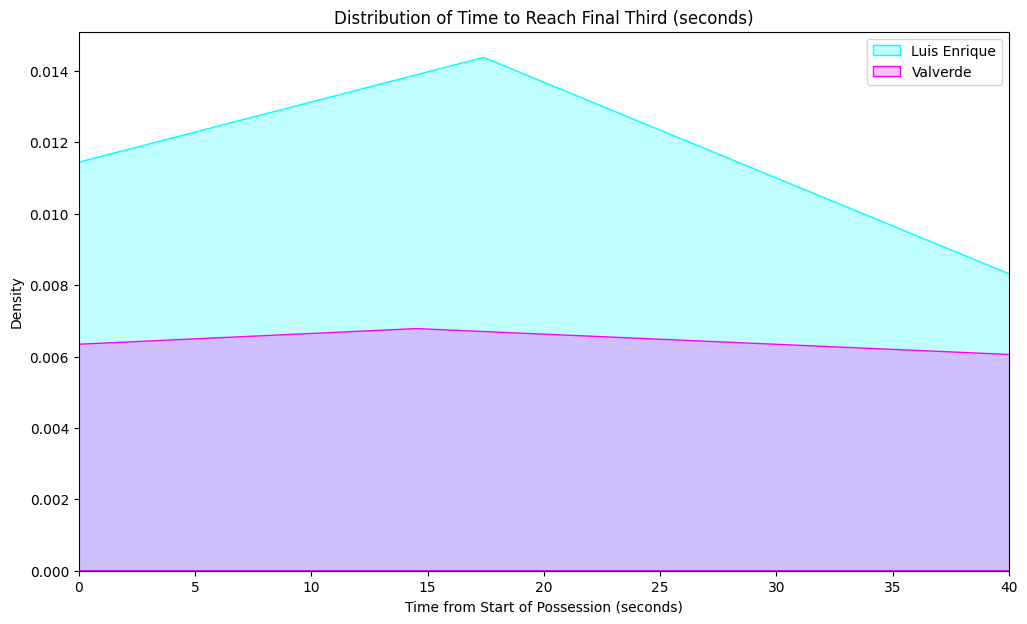

 Median Time to Reach Final Third
Luis Enrique: 11.00 seconds
Valverde: 10.00 seconds


In [42]:


#Visualize Time to Final Third
plt.figure(figsize=(12, 7))
sns.kdeplot(luis_chain_stats['time_to_final_third'].dropna(), label='Luis Enrique', fill=True, color='cyan')
sns.kdeplot(valverde_chain_stats['time_to_final_third'].dropna(), label='Valverde', fill=True, color='magenta')
plt.title('Distribution of Time to Reach Final Third (seconds)')
plt.xlabel('Time from Start of Possession (seconds)')
plt.xlim(0, 40) # Limit x-axis to see the main distribution clearly
plt.legend()
plt.show()

#  Print Median Values for a Clear Comparison
print(" Median Time to Reach Final Third")
print(f"Luis Enrique: {luis_chain_stats['time_to_final_third'].median():.2f} seconds")
print(f"Valverde: {valverde_chain_stats['time_to_final_third'].median():.2f} seconds")

# You can repeat the same visualization and median calculation for 'time_to_shot'


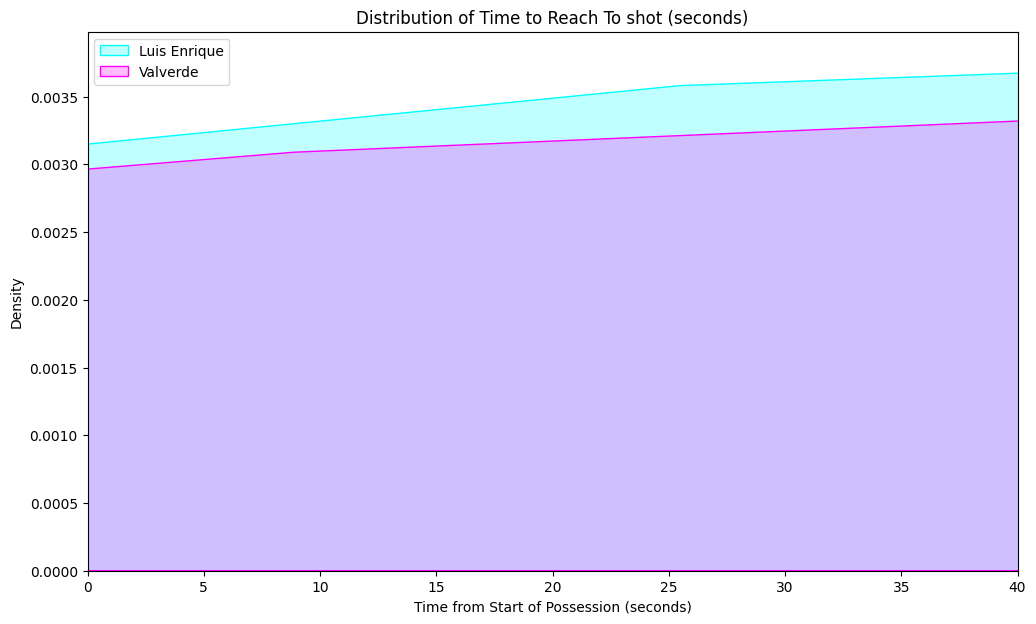

 Median Time to hit shot
Luis Enrique: 54.00 seconds
Valverde: 49.00 seconds


In [43]:


# Visualize Time to Shot
plt.figure(figsize=(12, 7))
sns.kdeplot(luis_chain_stats['time_to_shot'].dropna(), label='Luis Enrique', fill=True, color='cyan')
sns.kdeplot(valverde_chain_stats['time_to_shot'].dropna(), label='Valverde', fill=True, color='magenta')
plt.title('Distribution of Time to Reach To shot (seconds)')
plt.xlabel('Time from Start of Possession (seconds)')
plt.xlim(0, 40) # Limit x-axis to see the main distribution clearly
plt.legend()
plt.show()

#  Print Median Values for a Clear Comparison
print(" Median Time to hit shot")
print(f"Luis Enrique: {luis_chain_stats['time_to_shot'].median():.2f} seconds")
print(f"Valverde: {valverde_chain_stats['time_to_shot'].median():.2f} seconds")



In [44]:
# Filter for shot events for both eras
luis_shots = df_luis[df_luis['event_type'] == 'Shot']
valverde_shots = df_valverde[df_valverde['event_type'] == 'Shot']


In [45]:
# For Luis Enrique Era
total_goals_luis = (luis_shots['shot_outcome'] == 'Goal').sum()
total_xg_luis = luis_shots['shot_statsbomb_xg'].sum()
total_shots_luis = len(luis_shots)
avg_xg_per_shot_luis = luis_shots['shot_statsbomb_xg'].mean()

# For Valverde Era
total_goals_valverde = (valverde_shots['shot_outcome'] == 'Goal').sum()
total_xg_valverde = valverde_shots['shot_statsbomb_xg'].sum()
total_shots_valverde = len(valverde_shots)
avg_xg_per_shot_valverde = valverde_shots['shot_statsbomb_xg'].mean()

print('Luis Enrique:', total_goals_luis, total_xg_luis, avg_xg_per_shot_luis)
print('Valverde:', total_goals_valverde, total_xg_valverde, avg_xg_per_shot_valverde)


Luis Enrique: 312 247.263071799 0.13898992231534568
Valverde: 237 191.47608313130002 0.1287667001555481


# **What StatsBomb defines as “xG”**


>An Expected Goals (xG) value is the probability that a shot results in a goal, based on a model trained on thousands of prior shots. Values remain between 0 and 1, where 0.20 means ~20% scoring likelihood.



While basic xG models rely on features like shot location, angle, body part, and assist type, StatsBomb’s model goes further, using freeze‑frame data at the moment of each shot, which includes:

goalkeeper position and stance,

pressure and position of surrounding defenders,

positions of all other attackers in frame,

and even the height of the ball when struck

**Source** : StatsBomb blog archive www.blogarchive.statsbomb.com/articles/soccer/upgrading-expected-goals




In [46]:
# For Luis Enrique Era
total_goals_luis = (luis_shots['shot_outcome'] == 'Goal').sum()
total_xg_luis = luis_shots['shot_statsbomb_xg'].sum()
total_shots_luis = len(luis_shots)
avg_xg_per_shot_luis = luis_shots['shot_statsbomb_xg'].mean()

# For Valverde Era
total_goals_valverde = (valverde_shots['shot_outcome'] == 'Goal').sum()
total_xg_valverde = valverde_shots['shot_statsbomb_xg'].sum()
total_shots_valverde = len(valverde_shots)
avg_xg_per_shot_valverde = valverde_shots['shot_statsbomb_xg'].mean()

print(f"Luis Enrique: {total_goals_luis} goals | xG: {total_xg_luis:.2f} | Avg xG/shot: {avg_xg_per_shot_luis:.3f}")
print(f"Valverde:     {total_goals_valverde} goals | xG: {total_xg_valverde:.2f} | Avg xG/shot: {avg_xg_per_shot_valverde:.3f}")



Luis Enrique: 312 goals | xG: 247.26 | Avg xG/shot: 0.139
Valverde:     237 goals | xG: 191.48 | Avg xG/shot: 0.129


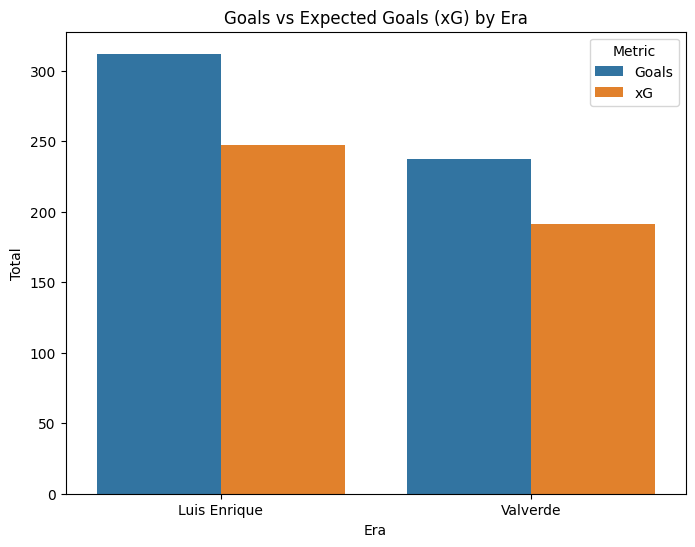

In [47]:
# Prepare data for bar chart
data = {
    'Era':['Luis Enrique','Luis Enrique','Valverde','Valverde'],
    'Metric':['Goals','xG','Goals','xG'],
    'Value':[total_goals_luis, total_xg_luis, total_goals_valverde, total_xg_valverde]
}
df_metrics = pd.DataFrame(data)

plt.figure(figsize=(8,6))
sns.barplot(data=df_metrics, x='Era', y='Value', hue='Metric')
plt.title('Goals vs Expected Goals (xG) by Era')
plt.ylabel('Total')
plt.show()


Point to be noted barca is scoring more goal relative to other teams in each era according to statsbomb Xg

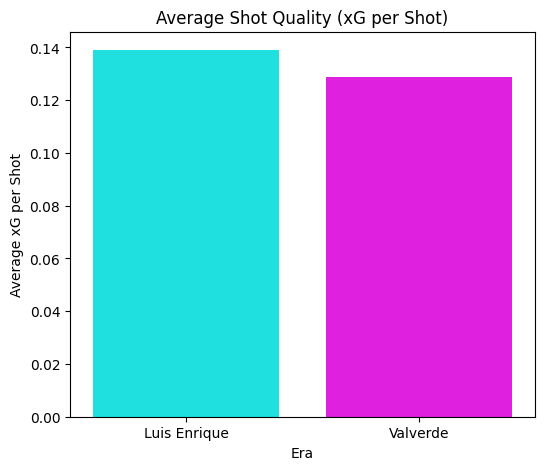

In [48]:
df_avgxg = pd.DataFrame({
    'Era': ['Luis Enrique', 'Valverde'],
    'Average xG per Shot': [avg_xg_per_shot_luis, avg_xg_per_shot_valverde]
})

plt.figure(figsize=(6,5))
sns.barplot(x='Era', y='Average xG per Shot', data=df_avgxg, palette=['cyan','magenta'])
plt.title('Average Shot Quality (xG per Shot)')
plt.show()


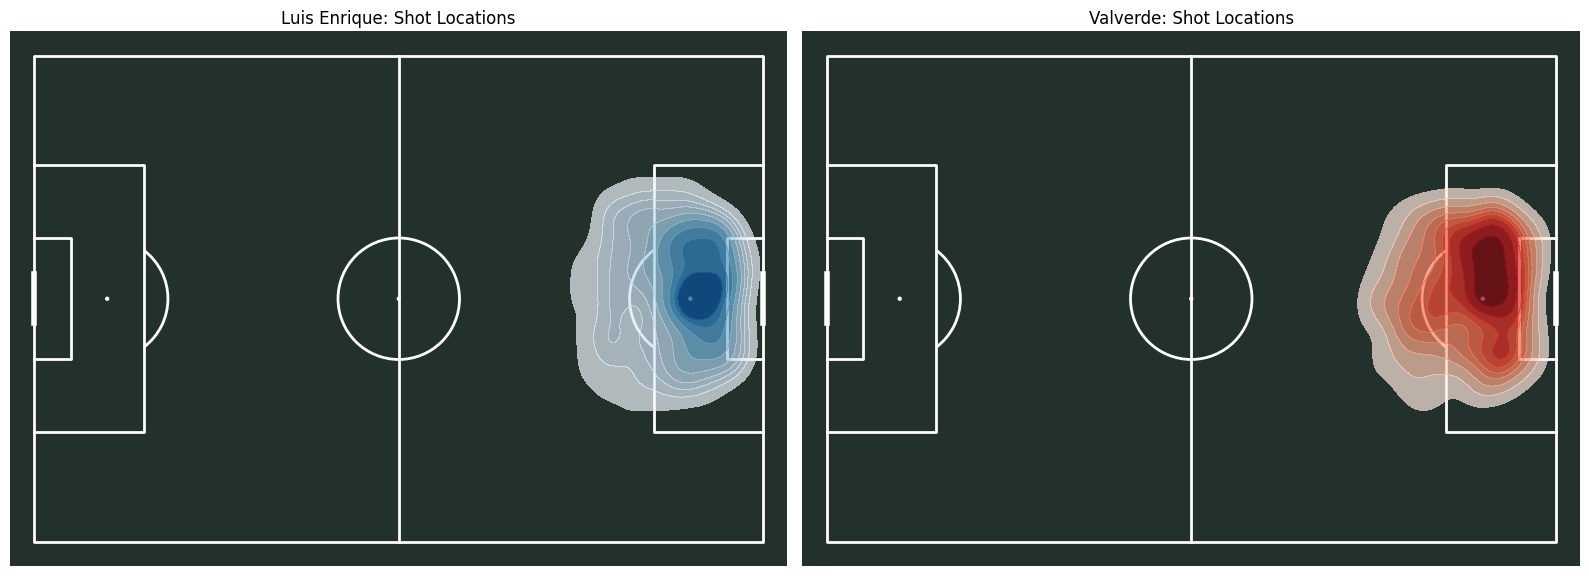

In [49]:


# Set up figure with two axes
pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='white')
fig, axs = pitch.draw(nrows=1, ncols=2, figsize=(16, 8))

# Luis Enrique's shots (left)
sns.kdeplot(
    x=luis_shots['location_x'],
    y=luis_shots['location_y'],
    fill=True,
    cmap='Blues',
    ax=axs[0],
    thresh=0.1,
    alpha=0.7
)
axs[0].set_title('Luis Enrique: Shot Locations', color='black')

# Valverde's shots (right)
sns.kdeplot(
    x=valverde_shots['location_x'],
    y=valverde_shots['location_y'],
    fill=True,
    cmap='Reds',
    ax=axs[1],
    thresh=0.1,
    alpha=0.7
)
axs[1].set_title('Valverde: Shot Locations', color='black')

plt.tight_layout()
plt.show()


# Conculsion Luis vs Valverde Attacking
## 1. How did they attack?
Luis Enrique's team made more forward-thinking passes and took slightly more time to get up the pitch.

Valverde's team moved a bit faster, but with fewer progressive passes.

Enrique: slower but more deliberate.

Valverde: quicker, but maybe less structured.

##2. Where were the shots coming from?
From your final pitch heatmap:

Both teams shot from central zones near the box, but…

Enrique's team had more variety and width, suggesting they moved defenders around before shooting important detail most shot was taken in front of goalpost

Valverde s team shot from closer, narrower spots, maybe relying more on quick or direct entries important detail most shot comes from left side of goal post maybe over realiance on left forward

## 3. Shot quality and finishing?
Enrique  team took slightly better shots (higher xG per shot).

They also outperformed their xG by a larger margin, meaning they didn’t just create better chances — they finished them better too.

## 4. How fast to the final third?
Median time to reach the attacking zone:

Enrique: 11 seconds

Valverde: 10 seconds

Not a huge gap. Valverde's team was just a bit more direct, but not wildly different.

